# Machine Learning Project: Heart Failure on the Rise in the Smurf Society

## by Beatriz Ferreira \& Joyce Ghosn

## Part 1: Linear Model (Baseline)

In [1]:
# =========================================================
# STEP 0 – IMPORTS & PATHS
# =========================================================
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# ---- Paths (adapt if needed) ----
DIR = r"C:\Users\Georges Ghosn\Desktop\ML beatrice\data\data_labeled"


X_TRAIN_PATH = fr"{DIR}\X_train.csv"
Y_TRAIN_PATH = fr"{DIR}\y_train.csv"
X_TEST_PATH  = fr"{DIR}\X_test.csv"
Y_TEST_PATH  = fr"{DIR}\y_test.csv"


# =========================================================
# STEP 1 – LOAD RAW DATA & BASIC CLEANING
# =========================================================
X_train_raw = pd.read_csv(X_TRAIN_PATH)
y_train = pd.read_csv(Y_TRAIN_PATH, header=None).squeeze()

X_test_raw = pd.read_csv(X_TEST_PATH)
y_test = pd.read_csv(Y_TEST_PATH, header=None).squeeze()

print("Raw shapes:")
print("  X_train_raw:", X_train_raw.shape, "| y_train:", y_train.shape)
print("  X_test_raw :", X_test_raw.shape,  "| y_test :", y_test.shape)

# Drop image filename (not used in Part 1)
X_train_raw = X_train_raw.drop(columns=["img_filename"])
X_test_raw  = X_test_raw.drop(columns=["img_filename"])
print("\nDropped column: img_filename")

print("\nColumns in X_train_raw:")
print(list(X_train_raw.columns))

print("\nMissing values per feature:")
print(X_train_raw.isna().sum())


Raw shapes:
  X_train_raw: (1000, 14) | y_train: (1000,)
  X_test_raw : (500, 14) | y_test : (500,)

Dropped column: img_filename

Columns in X_train_raw:
['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin', 'height', 'potassium', 'profession', 'sarsaparilla', 'smurfberry liquor', 'smurfin donuts', 'vitamin D', 'weight']

Missing values per feature:
age                  0
blood pressure       0
calcium              0
cholesterol          0
hemoglobin           0
height               0
potassium            0
profession           0
sarsaparilla         0
smurfberry liquor    0
smurfin donuts       0
vitamin D            0
weight               0
dtype: int64


In [2]:
# =========================================================
# STEP 2 – DEFINE FEATURE TYPES & CLEAN TEXT
# =========================================================

# Ordinal variables with natural order
ordinal_features = ["sarsaparilla", "smurfberry liquor", "smurfin donuts"]

# Nominal categorical variable
categorical_features = ["profession"]

# Everything else numeric
numeric_features = [c for c in X_train_raw.columns
                    if c not in ordinal_features + categorical_features]

print("\nNumeric features:", numeric_features)
print("Ordinal features:", ordinal_features)
print("Categorical features:", categorical_features)

# Clean string columns (lowercase / strip spaces)
for df in (X_train_raw, X_test_raw):
    for c in ordinal_features + categorical_features:
        df[c] = df[c].astype(str).str.strip().str.lower()



Numeric features: ['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin', 'height', 'potassium', 'vitamin D', 'weight']
Ordinal features: ['sarsaparilla', 'smurfberry liquor', 'smurfin donuts']
Categorical features: ['profession']


In [3]:
# =========================================================
# STEP 3 – ENCODING 
# =========================================================
from sklearn.compose import ColumnTransformer

levels = ["very low", "low", "moderate", "high", "very high"]

# Encoder-only transformer 
encoder = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),  # keep numeric as is for now
        ("ord", OrdinalEncoder(categories=[levels]*len(ordinal_features)),
         ordinal_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False),
         categorical_features)
    ],
    remainder="drop"
)

# Fit encoder on FULL training features (X_train_raw), no y involved
X_train_enc = encoder.fit_transform(X_train_raw)
X_test_enc  = encoder.transform(X_test_raw)

print("\nAfter encoding (before split):")
print("  X_train_enc shape:", X_train_enc.shape)
print("  X_test_enc  shape:", X_test_enc.shape)

# ---- Build feature names for the encoded data ----
num_names = numeric_features
ord_names = ordinal_features

ohe = encoder.named_transformers_["cat"]
prof_cats = list(ohe.categories_[0])
cat_names = [f"profession__{c}" for c in prof_cats]

encoded_feature_names = num_names + ord_names + cat_names

X_train_enc_df = pd.DataFrame(X_train_enc,
                              columns=encoded_feature_names,
                              index=X_train_raw.index)
X_test_enc_df = pd.DataFrame(X_test_enc,
                             columns=encoded_feature_names,
                             index=X_test_raw.index)

print("\nEncoded columns:")
print(encoded_feature_names)
print("\nHead of X_train_enc_df:")
print(X_train_enc_df.head())



After encoding (before split):
  X_train_enc shape: (1000, 18)
  X_test_enc  shape: (500, 18)

Encoded columns:
['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin', 'height', 'potassium', 'vitamin D', 'weight', 'sarsaparilla', 'smurfberry liquor', 'smurfin donuts', 'profession__administration and governance', 'profession__craftsmanship', 'profession__food production', 'profession__manufacturing', 'profession__resource extraction', 'profession__services']

Head of X_train_enc_df:
     age  blood pressure  calcium  cholesterol  hemoglobin  height  potassium  \
0   84.0          115.72     2.33        79.05       14.36    7.19       4.32   
1  137.0          110.72     2.25       125.24       16.53    7.44       4.29   
2  105.0          102.65     2.74       123.59       10.91    7.42       4.06   
3   86.0          116.28     2.37       136.83       15.69    7.35       4.63   
4  180.0          124.92     2.35       137.19       14.55    8.02       5.51   

   vitamin D  w

In [4]:
# =========================================================
# STEP 4 – TRAIN / VALIDATION SPLIT (AFTER ENCODING)
# =========================================================
from sklearn.model_selection import train_test_split

X_tr_enc, X_val_enc, y_tr, y_val = train_test_split(
    X_train_enc_df,
    y_train,
    test_size=0.2,
    random_state=42
)

print("\nEncoded train/val shapes:")
print("  X_tr_enc :", X_tr_enc.shape, "| y_tr :", y_tr.shape)
print("  X_val_enc:", X_val_enc.shape, "| y_val:", y_val.shape)



Encoded train/val shapes:
  X_tr_enc : (800, 18) | y_tr : (800,)
  X_val_enc: (200, 18) | y_val: (200,)


In [5]:
# =========================================================
# STEP 5 – SCALING 
# =========================================================
from sklearn.preprocessing import StandardScaler

# We want to scale: numeric + ordinal (they are now all numeric columns)
scale_cols = numeric_features + ordinal_features
print("\nColumns to scale:", scale_cols)

# Fit scaler ONLY on TRAIN split (no leakage)
scaler = StandardScaler()
X_tr_scaled_block  = scaler.fit_transform(X_tr_enc[scale_cols])
X_val_scaled_block = scaler.transform(X_val_enc[scale_cols])
X_test_scaled_block = scaler.transform(X_test_enc_df[scale_cols])

# Turn scaled blocks back to DataFrames
X_tr_scaled_numord  = pd.DataFrame(X_tr_scaled_block,
                                   columns=scale_cols,
                                   index=X_tr_enc.index)
X_val_scaled_numord = pd.DataFrame(X_val_scaled_block,
                                   columns=scale_cols,
                                   index=X_val_enc.index)
X_test_scaled_numord = pd.DataFrame(X_test_scaled_block,
                                    columns=scale_cols,
                                    index=X_test_enc_df.index)

# Categorical one-hot columns (we do NOT scale them)
cat_cols = [c for c in X_tr_enc.columns if c not in scale_cols]
print("\nCategorical (one-hot) columns:", cat_cols)

# Final matrices: scaled numeric+ordinal + raw one-hot
X_tr_final = pd.concat([X_tr_scaled_numord, X_tr_enc[cat_cols]], axis=1)
X_val_final = pd.concat([X_val_scaled_numord, X_val_enc[cat_cols]], axis=1)
X_test_final = pd.concat([X_test_scaled_numord, X_test_enc_df[cat_cols]], axis=1)

print("\nFINAL shapes after encoding + split + scaling:")
print("  X_tr_final :", X_tr_final.shape)
print("  X_val_final:", X_val_final.shape)
print("  X_test_final:", X_test_final.shape)
print("\nHead of X_tr_final:")
print(X_tr_final.head())



Columns to scale: ['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin', 'height', 'potassium', 'vitamin D', 'weight', 'sarsaparilla', 'smurfberry liquor', 'smurfin donuts']

Categorical (one-hot) columns: ['profession__administration and governance', 'profession__craftsmanship', 'profession__food production', 'profession__manufacturing', 'profession__resource extraction', 'profession__services']

FINAL shapes after encoding + split + scaling:
  X_tr_final : (800, 18)
  X_val_final: (200, 18)
  X_test_final: (500, 18)

Head of X_tr_final:
          age  blood pressure   calcium  cholesterol  hemoglobin    height  \
29   0.404898        0.497101  0.777981     1.469424   -1.725573 -1.116753   
535  1.599801       -0.558216 -0.772047     0.621023   -0.011369 -0.362933   
695  0.106172       -1.180468 -0.045472    -0.149875    1.071541 -1.217263   
557  0.039789       -0.085700 -2.951773     0.332108    0.056616  0.466269   
836 -0.192554       -0.709744  0.002967     0.713201 

### - FEATURE SELECTION (Correlation Filter)

In [6]:
# =========================================================
# STEP 6 – FEATURE SELECTION (CORRELATION FILTER)
# =========================================================
import pandas as pd
import numpy as np

# 1) Compute correlation only on the TRAINING SPLIT
corr_with_y = X_tr_final.corrwith(y_tr)

# 2) Sort by absolute value
corr_sorted = corr_with_y.abs().sort_values(ascending=False)
print("Feature correlations with target:\n")
print(corr_sorted)

# 3) Choose a simple threshold (no redundancy check)
threshold = 0.05   # keep all features with |corr| > 5%

selected_features = corr_sorted[corr_sorted > threshold].index.tolist()

print("\nSelected features (|corr| >", threshold, "):")
print(selected_features)
print("\nNumber of selected features:", len(selected_features))

# 4) Apply SAME feature mask to train, val, and test sets
X_tr_sel   = X_tr_final[selected_features].copy()
X_val_sel  = X_val_final[selected_features].copy()
X_test_sel = X_test_final[selected_features].copy()

print("\nShapes after selection:")
print("  X_tr_sel :", X_tr_sel.shape)
print("  X_val_sel:", X_val_sel.shape)
print("  X_test_sel:", X_test_sel.shape)


Feature correlations with target:

blood pressure                               0.669563
cholesterol                                  0.451772
weight                                       0.420106
smurfin donuts                               0.314281
profession__administration and governance    0.233719
age                                          0.214341
sarsaparilla                                 0.175704
profession__food production                  0.161442
hemoglobin                                   0.153278
profession__services                         0.136316
profession__resource extraction              0.110600
height                                       0.102758
smurfberry liquor                            0.084879
potassium                                    0.030637
calcium                                      0.011257
profession__manufacturing                    0.004299
profession__craftsmanship                    0.002207
vitamin D                                    0.

In [7]:
# =========================================================
# STEP 7 – COMPARE LINEAR MODELS ON VALIDATION SET
# =========================================================
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

results = []

# 1) Ordinary Linear Regression (no regularization)
lin_reg = LinearRegression()
lin_reg.fit(X_tr_sel, y_tr)
y_val_pred = lin_reg.predict(X_val_sel)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
results.append({
    "model": "LinearRegression",
    "alpha": None,
    "val_RMSE": rmse_val
})
print(f"LinearRegression – validation RMSE: {rmse_val:.4f}")


# 2) Ridge Regression (L2) with several alphas
ridge_alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

for a in ridge_alphas:
    ridge = Ridge(alpha=a, random_state=42)
    ridge.fit(X_tr_sel, y_tr)
    y_val_pred = ridge.predict(X_val_sel)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    results.append({
        "model": "Ridge",
        "alpha": a,
        "val_RMSE": rmse_val
    })
    print(f"Ridge(alpha={a}) – validation RMSE: {rmse_val:.4f}")


# 3) Lasso Regression (L1) with several alphas
lasso_alphas = [0.001, 0.01, 0.1, 1.0]

for a in lasso_alphas:
    lasso = Lasso(alpha=a, max_iter=10000, random_state=42)
    lasso.fit(X_tr_sel, y_tr)
    y_val_pred = lasso.predict(X_val_sel)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    results.append({
        "model": "Lasso",
        "alpha": a,
        "val_RMSE": rmse_val
    })
    print(f"Lasso(alpha={a}) – validation RMSE: {rmse_val:.4f}")


# =========================================================
# STEP 8 – SUMMARIZE & PICK BEST MODEL
# =========================================================
results_df = pd.DataFrame(results)
print("\n=== Validation RMSE summary ===")
print(results_df.sort_values("val_RMSE"))

# Identify best row
best_row = results_df.sort_values("val_RMSE").iloc[0]
best_model_name = best_row["model"]
best_alpha = best_row["alpha"]
best_rmse = best_row["val_RMSE"]

print("\nBest model on validation:")
print(f"  Model: {best_model_name}")
print(f"  Alpha: {best_alpha}")
print(f"  Val RMSE: {best_rmse:.4f}")


LinearRegression – validation RMSE: 0.0512
Ridge(alpha=0.01) – validation RMSE: 0.0512
Ridge(alpha=0.1) – validation RMSE: 0.0512
Ridge(alpha=1.0) – validation RMSE: 0.0512
Ridge(alpha=10.0) – validation RMSE: 0.0511
Ridge(alpha=100.0) – validation RMSE: 0.0506
Lasso(alpha=0.001) – validation RMSE: 0.0509
Lasso(alpha=0.01) – validation RMSE: 0.0540
Lasso(alpha=0.1) – validation RMSE: 0.0710
Lasso(alpha=1.0) – validation RMSE: 0.0710

=== Validation RMSE summary ===
              model    alpha  val_RMSE
5             Ridge  100.000  0.050558
6             Lasso    0.001  0.050851
4             Ridge   10.000  0.051068
3             Ridge    1.000  0.051173
2             Ridge    0.100  0.051184
1             Ridge    0.010  0.051185
0  LinearRegression      NaN  0.051186
7             Lasso    0.010  0.053962
8             Lasso    0.100  0.071045
9             Lasso    1.000  0.071045

Best model on validation:
  Model: Ridge
  Alpha: 100.0
  Val RMSE: 0.0506


In [8]:
# =========================================================
# STEP 9 — Retrain Ridge(α=100) on FULL TRAINING DATA (train + val)
# =========================================================

# Concatenate train + validation sets
X_full_sel = pd.concat([X_tr_sel, X_val_sel])
y_full_sel = pd.concat([y_tr, y_val])

# Train the final model
from sklearn.linear_model import Ridge
best_model = Ridge(alpha=100.0)
best_model.fit(X_full_sel, y_full_sel)

print("Final model trained on full training data.")


Final model trained on full training data.


In [9]:
# =========================================================
# STEP 10 — Evaluate the final selected model on the TEST set
# =========================================================

from sklearn.metrics import mean_squared_error
import numpy as np

y_test_pred = best_model.predict(X_test_sel)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("FINAL TEST RMSE:", rmse_test)


FINAL TEST RMSE: 0.05595976170785272


## PART 2: Nonlinear Models and Advanced Feature Selection

In [ ]:
# ========= PART 2 – STEP 0: REUSE PREPROCESSING FROM PART 1 =========
# IMPORTANT: This assumes you already ran all cells from Part 1
# up to the creation of: X_tr_final, X_val_final, X_test_final, y_tr, y_val, y_test, X_train_raw

import pandas as pd
from sklearn.model_selection import train_test_split

# ========= STEP 1: Rebuild full preprocessed TRAINING set =========
# Previously, the training set was split into:
#   - X_tr_final: 80% of training data
#   - X_val_final: 20% of training data
# Here we concatenate them to reconstruct the full preprocessed training matrix (1000 rows)
# This is necessary because Part 2 uses the full training set for nonlinear models
X_train_preprocessed = pd.concat([X_tr_final, X_val_final], axis=0)

# Reorder rows to match the original X_train_raw order
# This ensures consistency and traceability with the original data indices
# Note: It does not affect the model training but keeps everything aligned for analysis
X_train_preprocessed = X_train_preprocessed.loc[X_train_raw.index]


print("Full preprocessed TRAIN shape:", X_train_preprocessed.shape)
print("Original y_train shape       :", y_train.shape)


X_test_preprocessed = X_test_final.copy()

print("Preprocessed TEST shape      :", X_test_preprocessed.shape)
print("y_test shape                 :", y_test.shape)


X_learn = X_train_preprocessed.copy()
y_learn = y_train.copy()


X_train_inner, X_val_inner, y_train_inner, y_val_inner = train_test_split(
    X_learn,
    y_learn,
    test_size=0.2,   # inner validation = 20% of 1000 rows
    random_state=0,
)

# Print shapes to verify that the splits are correct
print("\nInner splits for Part 2:")
print("  X_train_inner:", X_train_inner.shape, "| y_train_inner:", y_train_inner.shape)
print("  X_val_inner  :", X_val_inner.shape,   "| y_val_inner  :", y_val_inner.shape)



Full preprocessed TRAIN shape: (1000, 18)
Original y_train shape       : (1000,)
Preprocessed TEST shape      : (500, 18)
y_test shape                 : (500,)

Inner splits for Part 2:
  X_train_inner: (800, 18) | y_train_inner: (800,)
  X_val_inner  : (200, 18) | y_val_inner  : (200,)


In [11]:
# =========================================================
# STEP 4 — Mutual Information Feature Selection
# =========================================================

from sklearn.feature_selection import mutual_info_regression 
import pandas as pd# Calculate mutual information between each feature and the target
mi_scores = mutual_info_regression(X_train_inner, y_train_inner, random_state=0)

# Convert scores into a pandas Series, label each score with the corresponding feature name
# Sort descending so the most informative features are at the top
mi_series = pd.Series(mi_scores, index=X_train_inner.columns).sort_values(ascending=False)

# Print all MI scores to inspect the contribution of each feature
print("=== MI on TRAIN_INNER (sorted) ===")
print(mi_series)

# Select the top K features (here K=10) according to their MI score
K = 10
features_mi = mi_series.head(K).index.tolist()

# Print the top-K features for reporting / later use
print(f"\nTop {K} MI features (train_inner only):")
for f in features_mi:
    print("-", f)


=== MI on TRAIN_INNER (sorted) ===
blood pressure                               0.229568
weight                                       0.095194
cholesterol                                  0.092712
age                                          0.078118
sarsaparilla                                 0.074157
potassium                                    0.073736
profession__craftsmanship                    0.053888
smurfin donuts                               0.043010
profession__food production                  0.017411
profession__administration and governance    0.016710
profession__manufacturing                    0.015976
vitamin D                                    0.015301
profession__services                         0.004859
profession__resource extraction              0.004254
smurfberry liquor                            0.000210
height                                       0.000000
hemoglobin                                   0.000000
calcium                                      0.

In [12]:
# =========================================================
# Step 5 – Wrapper: SequentialFeatureSelector with MLP
# =========================================================
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Define a small MLP regressor as the base model for the wrapper selection
base_mlp = MLPRegressor(
    hidden_layer_sizes=(16,),  # single hidden layer with 16 neurons
    max_iter=200,              # limit training iterations to avoid excessive compute
    random_state=0             # for reproducibility
)

# Define RMSE as a custom scoring function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Wrap RMSE for use as scoring in the feature selector
rmse_scorer = make_scorer(rmse, greater_is_better=False)


n_features_to_select = 8

# Initialize the Sequential Feature Selector (forward selection)
sfs_mlp = SequentialFeatureSelector(
    estimator=base_mlp,
    n_features_to_select=n_features_to_select,  # stop after 8 features
    direction="forward",                        # start with no features, add best at each step
    scoring=rmse_scorer,                        # use cross-validated RMSE to evaluate subsets
    cv=5,                                       # 5-fold CV on TRAIN_INNER
    n_jobs=-1                                   # use all cores for speed
)

# Fit the selector to TRAIN_INNER
print("Fitting SFS on TRAIN_INNER...")
sfs_mlp.fit(X_train_inner, y_train_inner)

# Get boolean mask of selected features
support_mask = sfs_mlp.get_support()

# Extract the actual feature names selected
features_sfs = X_train_inner.columns[support_mask].tolist()

# Print the final selected features
print("\n=== SFS + MLP features (train_inner only) ===")
for f in features_sfs:
    print("-", f)


Fitting SFS on TRAIN_INNER...

=== SFS + MLP features (train_inner only) ===
- age
- blood pressure
- profession__administration and governance
- profession__craftsmanship
- profession__food production
- profession__manufacturing
- profession__resource extraction
- profession__services


In [ ]:
# =========================================================
# STEP 6: EMBEDDED FEATURE SELECTION (RANDOM FOREST)
# =========================================================

from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Define a Random Forest regressor for embedded feature selection
# - n_estimators=300: number of trees in the forest
# - max_depth=10: limit tree depth to prevent overfitting
# - random_state=0: ensure reproducibility
# - n_jobs=-1: use all CPU cores
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    random_state=0,
    n_jobs=-1
)

# Fit the RF model on the inner training split
# RF automatically calculates feature importance based on reduction in impurity
rf_model.fit(X_train_inner, y_train_inner)

# Extract feature importances from the trained RF model
# Store them in a pandas Series for convenience and sorting
importances = pd.Series(rf_model.feature_importances_, index=X_train_inner.columns)
importances_sorted = importances.sort_values(ascending=False)

# Print all features sorted by importance
print("=== RF importances on TRAIN_INNER (sorted) ===")
print(importances_sorted)

# Select top K features (10 here) based on RF importance
# K=10 is a practical choice: enough to capture the most relevant features without including too many noisy ones
K = 10
features_embedded = importances_sorted.head(K).index.tolist()

# Print the top 10 features selected by RF
print(f"\nTop {K} RF features (train_inner only):")
for f in features_embedded:
    print("-", f)




=== RF importances on TRAIN_INNER (sorted) ===
blood pressure                               0.612875
potassium                                    0.102689
hemoglobin                                   0.082125
weight                                       0.042828
age                                          0.038352
cholesterol                                  0.029267
vitamin D                                    0.019516
height                                       0.019273
sarsaparilla                                 0.016281
calcium                                      0.013707
smurfberry liquor                            0.006833
smurfin donuts                               0.006745
profession__administration and governance    0.002414
profession__resource extraction              0.001945
profession__food production                  0.001754
profession__services                         0.001707
profession__craftsmanship                    0.000907
profession__manufacturing          

In [14]:
# =========================================================
# STEP 7: DEFINE FEATURE SETS FOR MODEL TRAINING
# =========================================================

# Baseline: all features from the inner training split
# - This represents the full feature space without any selection
all_features = X_train_inner.columns.tolist()

feature_sets = {
    "all_features": all_features,
    "mi_top10": features_mi,
    "rf_top10": features_embedded,
    "sfs_top8": features_sfs
}

# Print the feature sets to check their content
# - Useful to verify that the subsets were created correctly
# - Can also be referenced later when iterating over feature sets for model training
print(feature_sets)

# =========================================================
# Notes / interpretation for report:
# - This dictionary will allow systematic testing of each model
#   on different feature subsets.
# - Comparing model performance across these subsets helps understand:
#   - Which features are consistently important (robust across methods)
#   - Whether compact subsets can achieve similar performance as all features
# - This step sets up for hyperparameter tuning and model comparison (next step)

{'all_features': ['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin', 'height', 'potassium', 'vitamin D', 'weight', 'sarsaparilla', 'smurfberry liquor', 'smurfin donuts', 'profession__administration and governance', 'profession__craftsmanship', 'profession__food production', 'profession__manufacturing', 'profession__resource extraction', 'profession__services'], 'mi_top10': ['blood pressure', 'weight', 'cholesterol', 'age', 'sarsaparilla', 'potassium', 'profession__craftsmanship', 'smurfin donuts', 'profession__food production', 'profession__administration and governance'], 'rf_top10': ['blood pressure', 'potassium', 'hemoglobin', 'weight', 'age', 'cholesterol', 'vitamin D', 'height', 'sarsaparilla', 'calcium'], 'sfs_top8': ['age', 'blood pressure', 'profession__administration and governance', 'profession__craftsmanship', 'profession__food production', 'profession__manufacturing', 'profession__resource extraction', 'profession__services']}


In [15]:
# =========================================================
# STEP 8: DEFINE MODELS, PARAMETER GRIDS, AND FEATURE SETS
# =========================================================

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Dictionary storing all models to test, their hyperparameter grids, and allowed feature sets
# - This structure will allow systematic model comparison
# - Each key is a model name, each value is another dictionary with:
#     - 'estimator': the sklearn model object
#     - 'param_grid': hyperparameters for GridSearchCV
#     - 'feature_sets': list of feature subsets to try for that model
models_and_grids = {
    "RandomForest": {
        "estimator": RandomForestRegressor(random_state=0, n_jobs=-1),
        "param_grid": {
            "n_estimators": [100, 300],     # number of trees in the forest
            "max_depth": [None, 5, 10],     # limit tree depth to prevent overfitting
            "min_samples_leaf": [1, 5],     # minimum samples per leaf
            "max_features": ["sqrt", 0.5, 1.0],  # number of features considered for each split
        },
        # RF can perform well on all features or top subsets from MI/RF
        "feature_sets": ["all_features", "rf_top10", "mi_top10"],
    },
    "GradientBoosting": {
        "estimator": GradientBoostingRegressor(random_state=0),
        "param_grid": {
            "n_estimators": [100, 300],     # number of boosting stages
            "learning_rate": [0.01, 0.05, 0.1],  # shrinkage factor for each stage
            "max_depth": [2, 3, 4],         # max depth of individual trees
            "subsample": [0.6, 0.8, 1.0],   # fraction of samples for each stage
        },
        # Gradient Boosting usually works well with compact + all feature sets
        "feature_sets": ["all_features", "mi_top10", "rf_top10"],
    },
    "KNN": {
        "estimator": KNeighborsRegressor(),
        "param_grid": {
            "n_neighbors": [3, 5, 7, 9],   # number of neighbors
            "weights": ["uniform", "distance"],  # uniform = equal weight, distance = closer neighbors weigh more
            "p": [1, 2],                   # distance metric: 1 = Manhattan, 2 = Euclidean
        },
        # KNN is sensitive to high-dimensional spaces → use compact feature sets
        "feature_sets": ["all_features", "mi_top10", "sfs_top8"],
    },
    "MLP": {
        "estimator": MLPRegressor(
            max_iter=1000,         # maximum number of iterations for convergence
            early_stopping=True,   # stop training when validation score stops improving
            random_state=0
        ),
        "param_grid": {
            "hidden_layer_sizes": [(32,), (64,), (32, 16)],  # architecture options
            "alpha": [0.0001, 0.001, 0.01],                # L2 regularization
            "learning_rate_init": [0.001, 0.01],           # initial learning rate
        },
        # MLP generally prefers smaller, more informative feature sets to avoid overfitting
        "feature_sets": ["all_features", "mi_top10", "sfs_top8"],
    },
}

# =========================================================
# Notes / interpretation for report:
# - This dictionary sets up a systematic ML experiment:
#   1) For each model
#   2) For each allowed feature subset
#   3) Run GridSearchCV on X_train_inner to find best hyperparameters
#   4) Evaluate the best model on X_val_inner using RMSE
#   5) Store results for comparison
# - This allows us to compare:
#   - Model types (RF, GB, KNN, MLP)
#   - Feature selection methods (filter MI, wrapper SFS, embedded RF, all features)
# - We can then analyze which features and models generalize best to unseen data.



In [16]:
# =========================================================
# STEP 9: GRID SEARCH AND VALIDATION LOOP
# =========================================================

# Initialize list to store all results
results = []

# Loop over each model defined in models_and_grids
for model_name, cfg in models_and_grids.items():
    print(f"\n==============================")
    print(f"Model: {model_name}")
    print(f"==============================")
    
    base_estimator = cfg["estimator"]      # The sklearn estimator object
    param_grid = cfg["param_grid"]         # The hyperparameter search space
    fs_names = cfg["feature_sets"]         # Allowed feature subsets for this model
    
    # Loop over each feature subset
    for fs_name in fs_names:
        feature_list = feature_sets[fs_name]      # Actual columns corresponding to this subset
        print(f"\n  -> Feature set: {fs_name} ({len(feature_list)} features)")
        
        # Select only the columns in the current feature subset
        Xtr = X_train_inner[feature_list]        # Training data for this subset
        Xval = X_val_inner[feature_list]         # Validation data for this subset
        
        # Initialize GridSearchCV for this model and feature subset
        grid = GridSearchCV(
            estimator=base_estimator,                  # Model to train
            param_grid=param_grid,                     # Hyperparameter combinations
            scoring="neg_root_mean_squared_error",    # Use RMSE (negative because sklearn maximizes score)
            cv=5,                                      # 5-fold cross-validation on inner training split
            n_jobs=-1,                                 # Use all CPU cores
            verbose=0
        )
        
        # Fit GridSearchCV on inner training data
        # - This performs exhaustive search over all hyperparameter combinations
        # - Uses CV to estimate generalization performance
        grid.fit(Xtr, y_train_inner)
        
        # Retrieve the best estimator and CV score
        best_est = grid.best_estimator_
        best_cv_rmse = -grid.best_score_   # Convert negative RMSE back to positive
        
        # Evaluate the best model on inner validation split
        yval_pred = best_est.predict(Xval)
        val_rmse = np.sqrt(mean_squared_error(y_val_inner, yval_pred))
        
        # Print summary for this feature set
        print(f"     Best CV RMSE: {best_cv_rmse:.4f}")
        print(f"     Val RMSE    : {val_rmse:.4f}")
        print(f"     Best params : {grid.best_params_}")
        
        # Store results in a dictionary
        results.append({
            "model": model_name,
            "feature_set": fs_name,
            "n_features": len(feature_list),
            "best_params": grid.best_params_,
            "cv_rmse": best_cv_rmse,
            "val_rmse": val_rmse,
            "best_estimator": best_est,   # Keep the fitted estimator for later use
        })

# Convert results list to a pandas DataFrame for easier inspection
# - Exclude the estimator object for clean display
results_df = pd.DataFrame([
    {
        "model": r["model"],
        "feature_set": r["feature_set"],
        "n_features": r["n_features"],
        "cv_rmse": r["cv_rmse"],
        "val_rmse": r["val_rmse"],
        "best_params": r["best_params"],
    }
    for r in results
])

# Display results sorted by validation RMSE
print("\n=== Validation RMSE summary (sorted by val_rmse) ===")
display(results_df.sort_values("val_rmse"))

# =========================================================
# Notes / interpretation for report:
# - This loop implements the main evaluation workflow:
#   1) For each model type
#   2) For each allowed feature subset
#   3) Run GridSearchCV on X_train_inner (inner CV) to tune hyperparameters
#   4) Retrieve the best model and evaluate it on X_val_inner
#   5) Record CV RMSE and validation RMSE for comparison
# - The results_df gives a clear overview of which model + feature subset + hyperparameters
#   achieved the best performance on the inner validation set.
# - This procedure allows fair comparison between:
#     - Different models (RF, GB, KNN, MLP)
#     - Different feature selection strategies (all features, MI, RF, SFS)
# - This is exactly the workflow described in:
#   🔁 3) Main loop: GridSearchCV on inner train, RMSE on validation




Model: RandomForest

  -> Feature set: all_features (18 features)
     Best CV RMSE: 0.0442
     Val RMSE    : 0.0465
     Best params : {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 300}

  -> Feature set: rf_top10 (10 features)
     Best CV RMSE: 0.0438
     Val RMSE    : 0.0460
     Best params : {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 300}

  -> Feature set: mi_top10 (10 features)
     Best CV RMSE: 0.0468
     Val RMSE    : 0.0555
     Best params : {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 300}

Model: GradientBoosting

  -> Feature set: all_features (18 features)
     Best CV RMSE: 0.0403
     Val RMSE    : 0.0431
     Best params : {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.8}

  -> Feature set: mi_top10 (10 features)
     Best CV RMSE: 0.0450
     Val RMSE    : 0.0546
     Best params : {'learning_rate': 0.05, 'max_depth': 2, 'n_esti

,model,feature_set,n_features,cv_rmse,val_rmse,best_params
3,GradientBoosting,all_features,18,0.040309,0.043106,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est..."
5,GradientBoosting,rf_top10,10,0.039577,0.044680,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
1,RandomForest,rf_top10,10,0.043778,0.046019,"{'max_depth': None, 'max_features': 0.5, 'min_..."
0,RandomForest,all_features,18,0.044162,0.046521,"{'max_depth': None, 'max_features': 0.5, 'min_..."
9,MLP,all_features,18,0.055029,0.054520,"{'alpha': 0.01, 'hidden_layer_sizes': (32, 16)..."
4,GradientBoosting,mi_top10,10,0.044971,0.054625,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est..."
10,MLP,mi_top10,10,0.050424,0.055468,"{'alpha': 0.01, 'hidden_layer_sizes': (32, 16)..."
2,RandomForest,mi_top10,10,0.046818,0.055474,"{'max_depth': None, 'max_features': 0.5, 'min_..."
7,KNN,mi_top10,10,0.050635,0.057297,"{'n_neighbors': 9, 'p': 2, 'weights': 'distance'}"
6,KNN,all_features,18,0.053216,0.058280,"{'n_neighbors': 9, 'p': 2, 'weights': 'distance'}"


In [17]:
# =========================================================
# STEP 10: SELECT BEST MODEL BASED ON VALIDATION RMSE
# =========================================================

# Find the entry in results with the lowest validation RMSE
# - key=lambda d: d["val_rmse"] ensures we select the dictionary with the smallest val_rmse
best_entry = min(results, key=lambda d: d["val_rmse"])

# Print summary of the best model
print("\n=== Best model on validation ===")
print("Model       :", best_entry["model"])           # Model type (RF, GB, KNN, MLP)
print("Feature set :", best_entry["feature_set"])    # Which feature subset was used
print("n_features  :", best_entry["n_features"])     # Number of features used
print("Best params :", best_entry["best_params"])    # Best hyperparameters from GridSearchCV
print(f"CV RMSE     : {best_entry['cv_rmse']:.4f}")  # CV RMSE from GridSearchCV
print(f"Val RMSE    : {best_entry['val_rmse']:.4f}") # RMSE on inner validation split

# Store important info for later evaluation on the test set
best_model_name = best_entry["model"]                     # Name of the best model
best_feature_set_name = best_entry["feature_set"]        # Name of the feature set
best_feature_list = feature_sets[best_feature_set_name]  # Actual feature columns
best_model_val = best_entry["best_estimator"]            # Fitted estimator object




=== Best model on validation ===
Model       : GradientBoosting
Feature set : all_features
n_features  : 18
Best params : {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.8}
CV RMSE     : 0.0403
Val RMSE    : 0.0431


In [18]:
# =========================================================
# STEP 11: RETRAIN WINNING MODEL ON FULL TRAINING DATA
# =========================================================


# Find the best model entry again (just to be sure)
best_entry = min(results, key=lambda d: d["val_rmse"])

# Identify the feature set that gave the best validation performance
best_feature_set_name = best_entry["feature_set"]

# Get the actual list of columns for this feature set
best_feature_list = feature_sets[best_feature_set_name]

# Print the feature set name for reference
best_feature_set_name


'all_features'

In [19]:
# =========================================================
# STEP 12: INITIALIZE AND TRAIN FINAL MODEL
# =========================================================

# Retrieve the best hyperparameters from the validation search
best_params = best_entry["best_params"]


final_model = GradientBoostingRegressor(
    **best_params,  # unpack the hyperparameters dictionary
    random_state=0
)

# Select the columns corresponding to the winning feature set
X_learn = X_train_preprocessed[best_feature_list]

# Use the full training target vector
y_learn = y_train

final_model.fit(X_learn, y_learn)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=300,
                          random_state=0, subsample=0.8)

5.2 Evaluate ONCE on the untouched test set

In [20]:
# =========================================================
# STEP 13: EVALUATE FINAL MODEL ON TEST SET
# =========================================================

# Select the columns corresponding to the winning feature set for the test set
X_test_final = X_test_preprocessed[best_feature_list]

# Predict target values for the test set using the final model
y_test_pred = final_model.predict(X_test_final)

# Compute RMSE on the test set to assess final model performance
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print the final test RMSE
print("Final Test RMSE (Part 2):", test_rmse)



Final Test RMSE (Part 2): 0.04190927525651794


In [21]:
# =========================================================
# STEP 14: RETRAIN WINNING MODEL ON FULL TRAINING DATA
# =========================================================

from sklearn.ensemble import GradientBoostingRegressor

# Extract the best hyperparameters from the validation loop
best_params = best_entry["best_params"]

# Initialize the final Gradient Boosting model with the best hyperparameters
# and a fixed random_state for reproducibility
final_model = GradientBoostingRegressor(
    **best_params,
    random_state=0
)

# Use the full preprocessed training data (all 1000 samples) 
# and the selected features from the winning feature set
X_learn_full = X_train_preprocessed[best_feature_list]
y_learn_full = y_train

# Fit the model on the entire training set
# This ensures the final model has learned from all available data
final_model.fit(X_learn_full, y_learn_full)



GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=300,
                          random_state=0, subsample=0.8)

In [22]:
# =========================================================
# STEP 15: EVALUATE FINAL MODEL ON TEST SET
# =========================================================

X_test_final = X_test_preprocessed[best_feature_list]
y_test_pred = final_model.predict(X_test_final)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Final Test RMSE (Part 2):", test_rmse)


Final Test RMSE (Part 2): 0.04190927525651794


# Part 3 — Image Feature Extraction and Multimodal Modeling

3.1 Image Feature Extraction Using a Convolutional Neural Network is done in the google collab notebook 

In [23]:
# ============================
# PART 3 – 3.2  LOAD TARGETS + IMAGE FEATURES (LOCAL)
# ============================

# Make sure DIR, X_TRAIN_PREP_PATH, X_TEST_PREP_PATH, Y_TRAIN_PATH, Y_TEST_PATH are already defined

# 1) Load y with NO header (same as in Colab)
y_train = pd.read_csv(Y_TRAIN_PATH, header=None).iloc[:, 0].values
y_test  = pd.read_csv(Y_TEST_PATH,  header=None).iloc[:, 0].values

print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)

# 2) Paths for image feature CSVs
IMG_FEATS_TRAIN_PATH = fr"{DIR}\img_features_train.csv"
IMG_FEATS_TEST_PATH  = fr"{DIR}\img_features_test.csv"

# 3) Load image features (no header)
img_feats_train = pd.read_csv(IMG_FEATS_TRAIN_PATH, header=None).values
img_feats_test  = pd.read_csv(IMG_FEATS_TEST_PATH,  header=None).values

print("Image features train shape:", img_feats_train.shape)
print("Image features test  shape:", img_feats_test.shape)


y_train shape: (1000,)
y_test shape : (500,)
Image features train shape: (1000, 8)
Image features test  shape: (500, 8)


Build combined (tabular + image) feature matrices


In [24]:
# ============================
# BUILD COMBINED FEATURE MATRICES
# ============================

# Tabular features (already preprocessed from Part 1)
X_tab_train = X_train_preprocessed.values   # (1000, 18)
X_tab_test  = X_test_preprocessed.values    # (500, 18)

print("Tabular train shape:", X_tab_train.shape)
print("Tabular test  shape:", X_tab_test.shape)

# Concatenate along columns: [tabular || image_features]
X_comb_train = np.hstack([X_tab_train, img_feats_train])  # (1000, 26)
X_comb_test  = np.hstack([X_tab_test,  img_feats_test])   # (500, 26)

print("Combined train shape:", X_comb_train.shape)
print("Combined test  shape:", X_comb_test.shape)


Tabular train shape: (1000, 18)
Tabular test  shape: (500, 18)
Combined train shape: (1000, 26)
Combined test  shape: (500, 26)


 Reuse Gradient Boosting, with train/val split + final test

Now we repeat the train/validation/test logic, but on the combined features.

hyperparameter fine tuning using gridsearchcv 



In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# ============================
# 1) INNER TRAIN / VALIDATION SPLIT (ONE SPLIT FOR ALL EXPERIMENTS)
# ============================
X_train_inner_comb, X_val_inner_comb, y_train_inner, y_val_inner = train_test_split(
    X_comb_train,
    y_train,
    test_size=0.2,      # 80% train / 20% validation
    random_state=42
)

print("Inner train shape:", X_train_inner_comb.shape)
print("Validation shape :", X_val_inner_comb.shape)

# ============================
# 2) MUTUAL INFORMATION (ON INNER TRAIN ONLY)
# ============================
mi = mutual_info_regression(X_train_inner_comb, y_train_inner, random_state=42)
mi_sorted_idx = np.argsort(mi)[::-1]
mi_top20_idx  = mi_sorted_idx[:20]

print("Top-20 MI feature indices:", mi_top20_idx)

# ============================
# 3) DEFINE FEATURE SETS TO COMPARE
# ============================
feature_sets = {
    "all_26": np.arange(X_train_inner_comb.shape[1]),  # indices [0..25]
    "mi_top20": mi_top20_idx                           # indices of top-20 MI
}

# ============================
# 4) HYPERPARAM GRID FOR GRADIENT BOOSTING
# ============================
param_grid = {
    "n_estimators":    [200, 300, 500],
    "learning_rate":   [0.03, 0.05, 0.08],
    "max_depth":       [2, 3],
    "subsample":       [0.7, 0.85, 1.0],
    "min_samples_leaf":[1, 3, 5],
}

results = []

# ============================
# 5) LOOP OVER FEATURE SETS
# ============================
for name, idx in feature_sets.items():
    print("\n==============================")
    print(f"Feature set: {name} (n_features={len(idx)})")
    print("==============================")

    # Subset features
    X_train_fs = X_train_inner_comb[:, idx]
    X_val_fs   = X_val_inner_comb[:, idx]
    X_test_fs  = X_comb_test[:, idx]

    # Define base GB
    gb = GradientBoostingRegressor(random_state=42)

    # GridSearch on INNER TRAIN ONLY
    grid = GridSearchCV(
        estimator=gb,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",
        cv=5,
        n_jobs=-1
    )

    grid.fit(X_train_fs, y_train_inner)

    best_gb = grid.best_estimator_
    best_params = grid.best_params_

    # Validation RMSE
    y_val_pred = best_gb.predict(X_val_fs)
    rmse_val = np.sqrt(mean_squared_error(y_val_inner, y_val_pred))

    # Test RMSE (completely unseen)
    y_test_pred = best_gb.predict(X_test_fs)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print("Best params:", best_params)
    print("Validation RMSE:", rmse_val)
    print("Test RMSE      :", rmse_test)

    results.append({
        "feature_set": name,
        "n_features": len(idx),
        "best_params": best_params,
        "val_rmse": rmse_val,
        "test_rmse": rmse_test
    })

# ============================
# 6) SORT RESULTS BY VALIDATION RMSE
# ============================
results_sorted = sorted(results, key=lambda d: d["val_rmse"])

print("\n\n======= SUMMARY (sorted by validation RMSE) =======")
for r in results_sorted:
    print(
        f"{r['feature_set']:8s} | "
        f"n_feat={r['n_features']:2d} | "
        f"val_RMSE={r['val_rmse']:.5f} | "
        f"test_RMSE={r['test_rmse']:.5f} | "
        f"params={r['best_params']}"
    )


Inner train shape: (800, 26)
Validation shape : (200, 26)


Top-20 MI feature indices: [25 22 20 18 23  1  6  3 11  8 12  4  5  0  7  9 13 14  2 24]

Feature set: all_26 (n_features=26)
Best params: {'learning_rate': 0.08, 'max_depth': 2, 'min_samples_leaf': 3, 'n_estimators': 500, 'subsample': 0.7}
Validation RMSE: 0.028582145152364725
Test RMSE      : 0.03042522492324844

Feature set: mi_top20 (n_features=20)
Best params: {'learning_rate': 0.08, 'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 300, 'subsample': 0.7}
Validation RMSE: 0.02797412890221407
Test RMSE      : 0.030411823838885008


======= SUMMARY (sorted by validation RMSE) =======
mi_top20 | n_feat=20 | val_RMSE=0.02797 | test_RMSE=0.03041 | params={'learning_rate': 0.08, 'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 300, 'subsample': 0.7}
all_26   | n_feat=26 | val_RMSE=0.02858 | test_RMSE=0.03043 | params={'learning_rate': 0.08, 'max_depth': 2, 'min_samples_leaf': 3, 'n_estimators': 500, 'subsample': 0.7}


**Test our best model on the unseen test set**


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# ============================
# 1) INNER TRAIN / VALIDATION SPLIT (same as before)
# ============================
X_train_inner_comb, X_val_inner_comb, y_train_inner, y_val_inner = train_test_split(
    X_comb_train,
    y_train,
    test_size=0.2,
    random_state=42
)

print("Inner train shape:", X_train_inner_comb.shape)
print("Validation shape :", X_val_inner_comb.shape)

# ============================
# 2) APPLY MI-TOP20 FEATURE SELECTION
# ============================
# mi_top20_idx already computed from mutual_info_regression
selected_idx = mi_top20_idx   # length 20

X_train_inner_fs = X_train_inner_comb[:, selected_idx]
X_val_inner_fs   = X_val_inner_comb[:, selected_idx]
X_test_fs        = X_comb_test[:,       selected_idx]

print("Train FS shape:", X_train_inner_fs.shape)
print("Val   FS shape:", X_val_inner_fs.shape)
print("Test  FS shape:", X_test_fs.shape)

# ============================
# 3) FINAL MODEL WITH BEST HYPERPARAMETERS
# ============================
best_params = {
    "learning_rate": 0.08,
    "max_depth": 2,
    "min_samples_leaf": 1,
    "n_estimators": 300,
    "subsample": 0.7
}

final_gb = GradientBoostingRegressor(
    **best_params,
    random_state=42
)

# Train ONLY on inner train (no test leakage)
final_gb.fit(X_train_inner_fs, y_train_inner)

# ============================
# 4) VALIDATION PERFORMANCE
# ============================
y_val_pred = final_gb.predict(X_val_inner_fs)
rmse_val_final = np.sqrt(mean_squared_error(y_val_inner, y_val_pred))
print("FINAL GB (MI-top20) – Validation RMSE:", rmse_val_final)

# ============================
# 5) TEST PERFORMANCE (UNSEEN DATA)
# ============================
y_test_pred = final_gb.predict(X_test_fs)
rmse_test_final = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("FINAL GB (MI-top20) – Test RMSE:", rmse_test_final)


Inner train shape: (800, 26)
Validation shape : (200, 26)
Train FS shape: (800, 20)
Val   FS shape: (200, 20)
Test  FS shape: (500, 20)
FINAL GB (MI-top20) – Validation RMSE: 0.02797412890221407
FINAL GB (MI-top20) – Test RMSE: 0.030411823838885008


# Part 4: Understanding Heart Failure in Smurf Society

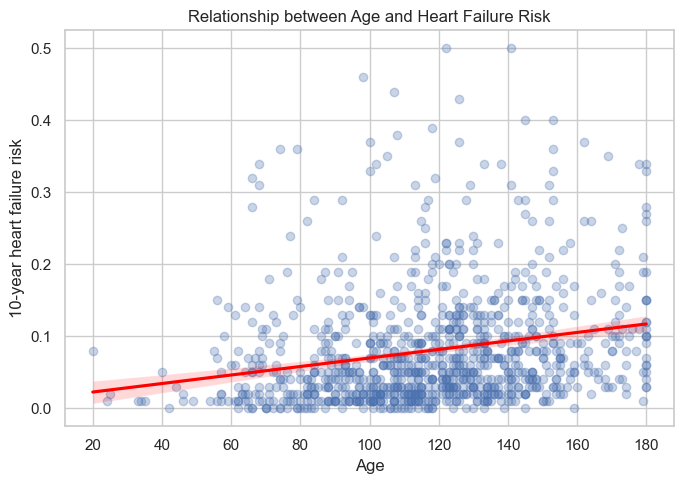

C:\Users\Georges Ghosn\AppData\Local\Temp\ipykernel_3892\759135331.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["bp_bin", "chol_bin"])["risk"]


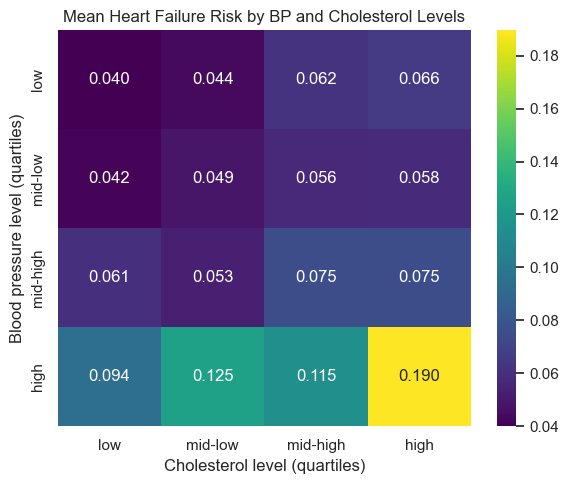

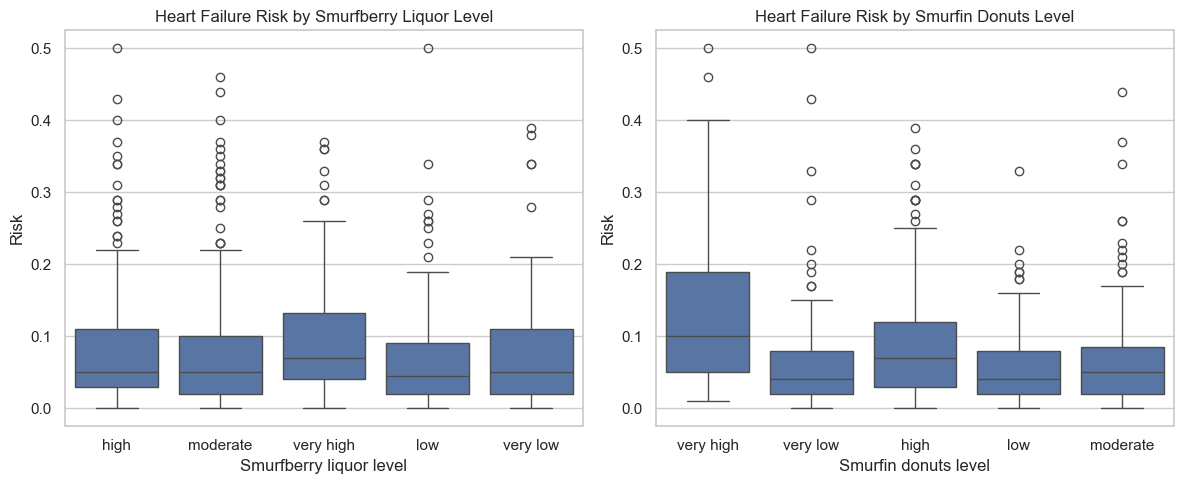

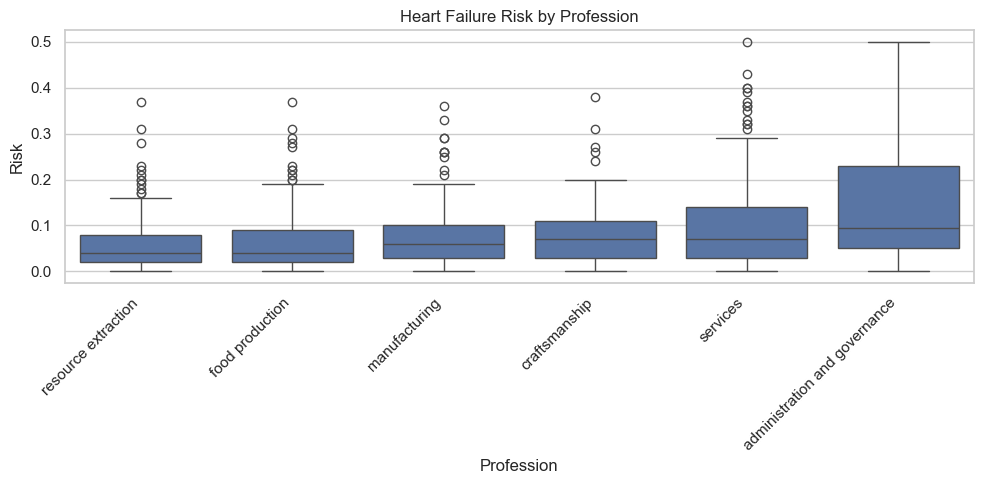

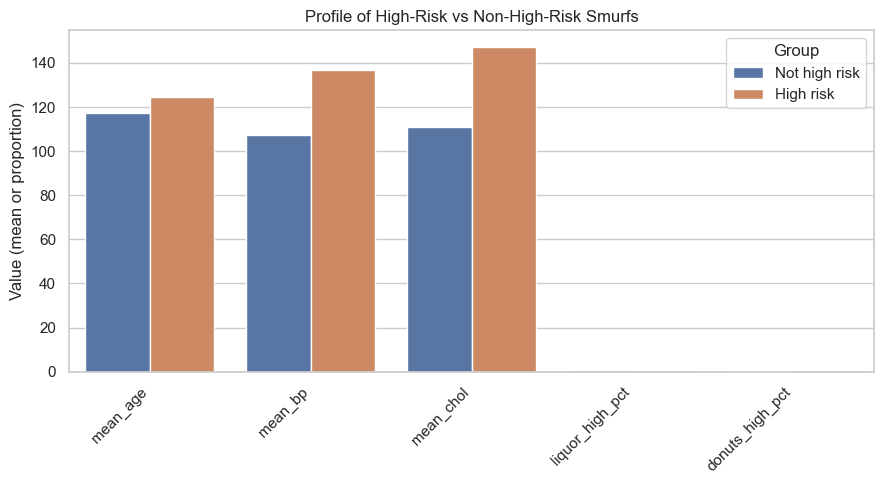

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook")

# =====================================================
# 1. BUILD MAIN DATAFRAMES FROM EXISTING VARIABLES
# =====================================================

# ---- Train DF: original tabular + true risk ----
df_train = X_train_raw.copy()
df_train = df_train.reset_index(drop=True)
df_train["risk"] = y_train  # true heart failure risk

# ---- Test DF: original tabular + true risk ----
df_test = X_test_raw.copy()
df_test = df_test.reset_index(drop=True)
df_test["risk"] = y_test

# OPTIONAL: if you have different prediction vectors, rename them first:
# y_test_pred_tab  = <your Part 2 tabular-only predictions>
# y_test_pred_multi = <your Part 3 multimodal predictions>

# Example (adapt if needed):
# df_test["risk_pred_tab"]   = y_test_pred_tab
# df_test["risk_pred_multi"] = y_test_pred_multi

# =====================================================
# 2. V1 – AGE VS RISK (H1)
# =====================================================

plt.figure(figsize=(7, 5))
sns.regplot(
    data=df_train,
    x="age",
    y="risk",
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"}
)
plt.title("Relationship between Age and Heart Failure Risk")
plt.xlabel("Age")
plt.ylabel("10-year heart failure risk")
plt.tight_layout()
plt.show()

# =====================================================
# 3. V2 – BP & CHOLESTEROL VS RISK (H2)
#    Option: heatmap of mean risk by BP/Cholesterol bins
# =====================================================

# Create bins (quartiles) for BP and cholesterol
df_train["bp_bin"] = pd.qcut(df_train["blood pressure"], q=4,
                             labels=["low", "mid-low", "mid-high", "high"])
df_train["chol_bin"] = pd.qcut(df_train["cholesterol"], q=4,
                               labels=["low", "mid-low", "mid-high", "high"])

pivot_risk = (
    df_train
    .groupby(["bp_bin", "chol_bin"])["risk"]
    .mean()
    .reset_index()
    .pivot(index="bp_bin", columns="chol_bin", values="risk")
)

plt.figure(figsize=(6, 5))
sns.heatmap(pivot_risk, annot=True, fmt=".3f", cmap="viridis")
plt.title("Mean Heart Failure Risk by BP and Cholesterol Levels")
plt.xlabel("Cholesterol level (quartiles)")
plt.ylabel("Blood pressure level (quartiles)")
plt.tight_layout()
plt.show()

# =====================================================
# 4. V3 – LIFESTYLE: LIQUOR & DONUTS VS RISK (H3)
# =====================================================

# NOTE: adjust column names if slightly different in your dataframe
liquor_col = "smurfberry liquor"
donuts_col = "smurfin donuts"

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_train, x=liquor_col, y="risk")
plt.title("Heart Failure Risk by Smurfberry Liquor Level")
plt.xlabel("Smurfberry liquor level")
plt.ylabel("Risk")

plt.subplot(1, 2, 2)
sns.boxplot(data=df_train, x=donuts_col, y="risk")
plt.title("Heart Failure Risk by Smurfin Donuts Level")
plt.xlabel("Smurfin donuts level")
plt.ylabel("Risk")

plt.tight_layout()
plt.show()

# =====================================================
# 5. V4 – RISK BY PROFESSION (H4)
# =====================================================

plt.figure(figsize=(10, 5))
# sort professions by mean risk to make it readable
order_prof = (
    df_train.groupby("profession")["risk"]
    .mean()
    .sort_values()
    .index
)

sns.boxplot(data=df_train, x="profession", y="risk", order=order_prof)
plt.title("Heart Failure Risk by Profession")
plt.xlabel("Profession")
plt.ylabel("Risk")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# =====================================================
# 6. V5 – HIGH-RISK PROFILE: HIGH vs OTHER (H5) - ROBUST VERSION
# =====================================================

# Define high-risk threshold (adapt if needed)
high_risk_threshold = 0.30
df_train["high_risk"] = df_train["risk"] >= high_risk_threshold

liquor_col = "smurfberry liquor"
donuts_col = "smurfin donuts"

# Helper: robust way to create "high consumption" flags
import numpy as np

def make_high_flag(series, q=0.75, name="var"):
    """
    Create a boolean 'high' flag for a pandas Series.
    - If numeric -> use quantile.
    - If non-numeric -> use ordered category codes + quantile.
    """
    s = series

    # If it's a DataFrame (e.g. duplicate column names), take first column
    if isinstance(s, pd.DataFrame):
        s = s.iloc[:, 0]

    # If numeric -> straightforward
    if np.issubdtype(s.dtype, np.number):
        thresh = s.quantile(q)
        high_flag = s >= thresh
        return high_flag, thresh

    # If not numeric -> use category codes as a proxy for order
    s_cat = s.astype("category")
    codes = s_cat.cat.codes  # integer codes 0,1,2,...
    thresh_code = np.quantile(codes, q)
    high_flag = codes >= thresh_code
    return high_flag, thresh_code

# Build high-consumption flags for liquor and donuts
df_train["liquor_high"], liquor_thr = make_high_flag(df_train[liquor_col], q=0.75, name="liquor")
df_train["donuts_high"], donuts_thr = make_high_flag(df_train[donuts_col], q=0.75, name="donuts")

# Aggregate stats for high-risk vs others
profiling = (
    df_train
    .groupby("high_risk")
    .agg(
        mean_age=("age", "mean"),
        mean_bp=("blood pressure", "mean"),
        mean_chol=("cholesterol", "mean"),
        liquor_high_pct=("liquor_high", "mean"),
        donuts_high_pct=("donuts_high", "mean"),
    )
    .reset_index()
)

# Convert boolean to label
profiling["group"] = profiling["high_risk"].map({False: "Not high risk", True: "High risk"})

# Reshape for plotting
profiling_melt = profiling.melt(
    id_vars=["group"],
    value_vars=["mean_age", "mean_bp", "mean_chol", "liquor_high_pct", "donuts_high_pct"],
    var_name="metric",
    value_name="value"
)

plt.figure(figsize=(9, 5))
sns.barplot(
    data=profiling_melt,
    x="metric",
    y="value",
    hue="group"
)
plt.title("Profile of High-Risk vs Non-High-Risk Smurfs")
plt.xlabel("")
plt.ylabel("Value (mean or proportion)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Group")
plt.tight_layout()
plt.show()




## Get y predict on the unlabled x train


In [34]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

# =========================================================
# 0) PATHS FOR UNLABELED DATA
# =========================================================
DIR_UNLAB = r"C:\Users\Georges Ghosn\Desktop\ML beatrice\data\data_unlabeled"  # <-- adapt if needed

X_UNLAB_PATH      = fr"{DIR_UNLAB}\X.csv"


IMG_FEAT_UNLAB_PATH = fr"{DIR_UNLAB}\image_features_unlabeled.csv"
df_img_unlab = pd.read_csv(IMG_FEAT_UNLAB_PATH)

# =========================================================
# 1) LOAD & CLEAN UNLABELED TABULAR DATA (LIKE PART 1)
# =========================================================
X_unlab_raw = pd.read_csv(X_UNLAB_PATH)

# keep filenames if you ever need them, but drop from features
img_filenames_unlab = X_unlab_raw["img_filename"].copy()
X_unlab_raw = X_unlab_raw.drop(columns=["img_filename"])

# same string cleaning as in Joyce(7) for train/test
for col in ["sarsaparilla", "smurfberry liquor", "smurfin donuts", "profession"]:
    X_unlab_raw[col] = X_unlab_raw[col].str.strip().str.lower()

print("Unlabeled raw shape:", X_unlab_raw.shape)

# =========================================================
# 2) APPLY THE SAME ENCODER AS PART 1
#    (encoder is already fitted on X_train_raw)
# =========================================================
X_unlab_enc = encoder.transform(X_unlab_raw)

# use the same column order as the preprocessed train
X_unlab_preprocessed = pd.DataFrame(
    X_unlab_enc,
    columns=X_train_preprocessed.columns,
    index=X_unlab_raw.index
)

print("Unlabeled preprocessed shape:", X_unlab_preprocessed.shape)

# =========================================================
# 3) LOAD IMAGE FEATURES FOR UNLABELED DATA
# =========================================================
df_img_unlab = pd.read_csv(IMG_FEAT_UNLAB_PATH)
print(df_img_unlab.head())
print(df_img_unlab.columns)

# Drop the filename column – keep only the 8 numeric feature columns
img_feats_unlab = df_img_unlab.drop(columns=["img_filename"]).values

print("Unlabeled image features shape:", img_feats_unlab.shape)
# should be (500, 8)

# 4) BUILD COMBINED (TABULAR + IMAGE) FEATURES FOR UNLABELED
X_tab_unlab  = X_unlab_preprocessed.values              # (500, 18)
X_comb_unlab = np.hstack([X_tab_unlab, img_feats_unlab])  # (500, 26)

print("Combined unlabeled shape:", X_comb_unlab.shape)

# 5) SELECT MI-TOP20 FEATURES
X_comb_train_fs = X_comb_train[:, mi_top20_idx]
X_comb_unlab_fs = X_comb_unlab[:, mi_top20_idx]

print("Train FS shape:", X_comb_train_fs.shape)
print("Unlabeled FS shape:", X_comb_unlab_fs.shape)

# 6) REFIT GB ON FULL LABELED DATA
final_gb = GradientBoostingRegressor(**best_params, random_state=42)
final_gb.fit(X_comb_train_fs, y_train)

# 7) PREDICT ON UNLABELED
y_pred_unlab = final_gb.predict(X_comb_unlab_fs)

df_pred = pd.DataFrame({"y_pred": y_pred_unlab})
df_pred.to_csv("y_pred.csv", index=False)

print("Saved predictions to y_pred.csv; shape:", df_pred.shape)
print(df_pred.head())


Unlabeled raw shape: (500, 13)
Unlabeled preprocessed shape: (500, 18)
  img_filename  img_feat_1  img_feat_2  img_feat_3  img_feat_4  img_feat_5  \
0  heart_0.png    0.126856         0.0         0.0    0.224516         0.0   
1  heart_1.png    0.120087         0.0         0.0    0.273446         0.0   
2  heart_2.png    0.194051         0.0         0.0    0.095571         0.0   
3  heart_3.png    0.191699         0.0         0.0    0.135619         0.0   
4  heart_4.png    0.219076         0.0         0.0    0.060995         0.0   

   img_feat_6  img_feat_7  img_feat_8  
0    0.226683         0.0    0.021235  
1    0.256904         0.0    0.015540  
2    0.148882         0.0    0.020996  
3    0.175619         0.0    0.012978  
4    0.124407         0.0    0.018527  
Index(['img_filename', 'img_feat_1', 'img_feat_2', 'img_feat_3', 'img_feat_4',
       'img_feat_5', 'img_feat_6', 'img_feat_7', 'img_feat_8'],
      dtype='object')
Unlabeled image features shape: (500, 8)
Combined unlab

In [35]:
df_pred.to_csv("y_pred.csv", index=False)
